### Segmentation of a blood vessel dataset containing large images

The training is done by randomly croping the images instead of using the entire images.

To download the dataset, run the following cell:

In [ ]:
# ! pip install lightning
# ! pip install tensorboard

In [ ]:
# from dataset_thin_region import download
# download(directory='data')

# Functions

In [13]:
def get_image_label_prediction(model, dataset, img_idx):
    """
    Obtains the original image, equalized image, label, filename, and prediction for a given image index.

    Parameters
    ----------
        * model (torch.nn.Module): The model used for prediction.
        * dataset (torch.utils.data.Dataset): The dataset containing the images.
        * img_idx (int): The index of the image to retrieve.

    Returns
    -------
        * img_or (numpy.ndarray): The original image.
        * img_equalized (numpy.ndarray): The equalized image.
        * label (int): The label of the image.
        * filename (str): The filename of the image.
        * pre/d (torch.Tensor): The prediction of the model for the image.
    """
    # Get original image from dataset
    img_or, _ = dataset.get_item(img_idx)
    img_or = np.array(img_or)
    # Get equalized image and its label
    img_equalized, label = dataset[img_idx]
    # Get filename
    filename = dataset.img_file_paths[img_idx].stem

    # Prediction
    with torch.no_grad():
        pred = model(img_equalized[None].to('cuda')).cpu()

    return img_or, img_equalized, label, filename, pred

def get_inference_iou(model, dataset):
    """
    Calculates the Intersection over Union (IoU) for each image in the dataset.

    Parameters
    ----------
        * model (object): The trained model used for prediction.
        * dataset (object): The dataset containing the images and labels.

    Returns
    -------
        * prediction_summary (DataFrame): A DataFrame containing the image index and the corresponding IoU.
    """
    # Define columns names
    columns_ = ['img_idx', 'prediction_iou']
    # Create dataframe
    prediction_summary = pd.DataFrame(columns = columns_)
    # Get dataset len
    dataset_len = len(dataset)

    for img_idx in range(dataset_len):

        img_or, img_equalized, label, filename, pred = get_image_label_prediction(model, dataset, img_idx)
        iou = perf_funcs.segmentation_accuracy(pred, label[None], meas = 'iou')

        # A dictionary to store the data
        results_dict = {
            "img_idx" : img_idx,
            "prediction_iou" : iou.numpy(),
        }

        # Convert the dict to dataframe
        df_result = pd.DataFrame([results_dict])
        # Concact df_result with prediction_summary to append a new row
        prediction_summary = pd.concat([prediction_summary, df_result])

    # Reset indexes
    prediction_summary.reset_index(drop = True, inplace = True)

    return prediction_summary




In [9]:
def load_model_with_checkpoint(checkpoint_path, model):
    """
    Loads a PyTorch model with a checkpoint.

    Parameters
    ----------
        * checkpoint_path (str): The path to the checkpoint file.
        * model (nn.Module): The PyTorch model to load the checkpoint into.

    Returns
    -------
        * nn.Module: The PyTorch model with the loaded checkpoint.
    """
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda'))

    # Extract the state dictionary from the checkpoint
    state_dict = checkpoint['state_dict']

    # Create a new dictionary to store the model state
    new_state_dict = {}

    # Iterate over each item in the state dictionary
    for k, v in state_dict.items():
        # If the item's key starts with 'model.', remove this prefix from the key
        # and add the item to the new state dictionary
        if k.startswith('model.'):
            new_state_dict[k[6:]] = v

    # Load the model state from the new state dictionary
    model.load_state_dict(new_state_dict)

    # Put the model in evaluation mode
    model.eval()
    model.cuda()

    return model

In [10]:
import os 
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Training

In [4]:
%%time
import random
from pathlib import Path
import matplotlib.pyplot as plt
import torch

import train_thin_regions_lightning as train_lightning
import dataset_thin_region as dataset
import torchtrainer

import torchtrainer.models.resunet as resunet
from torchtrainer import perf_funcs

import pandas as pd
import numpy as np
import plotly.express as px

img_path = '/home/wesleygalvao/Documents/repositorios/thin-object-selection/data/ThinObject5K_fine_tuning/images'
label_path = '/home/wesleygalvao/Documents/repositorios/thin-object-selection/data/ThinObject5K_fine_tuning/masks'

params = {
    # Dataset
    'img_dir': Path(img_path),
    'label_dir': Path(label_path),
    'crop_size': (256, 256),          
    'train_val_split': 0.1,
    # Model
    'model_layers': (3,3,3,3), 
    'model_channels': (16,32,64,128), 
    'model_type': 'unet',
    # Training
    'epochs': 100,
    'lr': 0.01,
    'batch_size_train': 8,
    'batch_size_valid': 8, #132,
    'momentum': 0.9,
    'weight_decay': 0.,
    'seed': 12,
    'loss': 'cross_entropy',
    'scheduler_power': 0.9,
    'class_weights': (0.3414, 0.6586),
    # Efficiency
    'device': 'cuda',
    'num_workers': 3,  # 3 is a good compromise
    'use_amp': True,
    'pin_memory': False,
    'non_blocking': False,
    # Logging
    'log_dir': 'logs',
    'experiment':'unet_l_3_3_3_3_c_16_32_64_128_e_100_lr_0.01_bs_8',
    'save_every':1,                
    'save_best':True,
    # Other
    'resume': False,
    'meta': None
}



CPU times: user 1.82 s, sys: 714 ms, total: 2.53 s
Wall time: 2.56 s


In [5]:
# Load dataset
ds_train, ds_valid = dataset.create_datasets(img_path, label_path)

In [41]:
%%time
#Train using pure Pytorch
#logger, ds_train, ds_valid, model = train_pytorch.run(params)
#Train using Pytorch Lightning
trainer, ds_train, ds_valid, model = train_lightning.run(params)
logger = trainer.loggers[1]

Seed set to 12
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | loss_func | CrossEntropyLoss | 0     
1 | model     | ResUNet          | 1.8 M 
-----------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.078     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/home/wesleygalvao/anaconda3/envs/mestrado_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

CPU times: user 6h 4min 16s, sys: 16min 10s, total: 6h 20min 27s
Wall time: 6h 21min 27s


/home/wesleygalvao/anaconda3/envs/mestrado_env/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


# View results

For viewing the logs, run the following command:


```bash
~/Documents/repositorios/Pytorch-template/recipes/thin_regions/logs/unet_l_1_1_1_c_16_32_64$ tensorboard --logdir=logs/fit
```

## Training logs

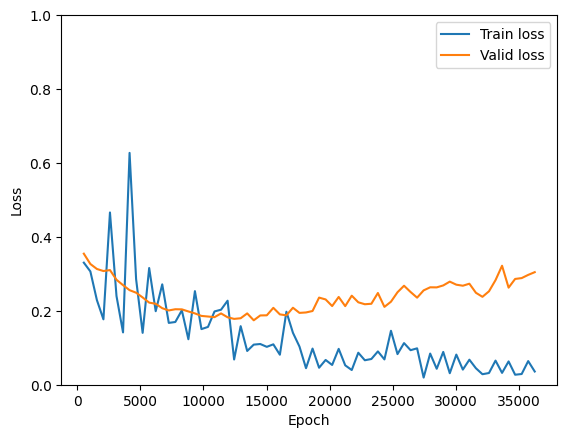

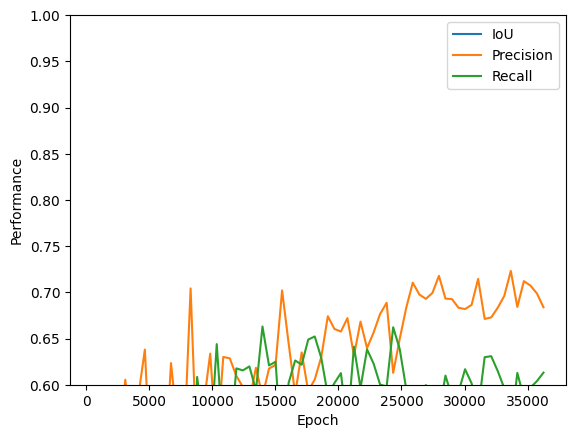

In [47]:
# Plot results
def plot_metrics(logger, type='lt'):
    '''Plot losses and IoU. `lt` is the logger used in Lightning.'''

    if type=='lt':
        metrics = logger.metrics
        epochs, _ = zip(*metrics['val_loss'])
        metrics = [list(zip(*metrics[k]))[1] for k in ['train_loss', 'val_loss', 'iou', 'prec', 'rec']]
        train_loss, valid_loss, iou, prec, rec = metrics    
    elif type=='pt':
        epochs, metrics = zip(*logger.data.items())
        train_loss, valid_loss, iou, prec, rec = zip(*metrics)

    plt.figure()
    plt.plot(epochs, train_loss, label='Train loss')
    plt.plot(epochs, valid_loss, label='Valid loss')
    plt.ylim((0, 1))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.figure()
    plt.plot(epochs, iou, label='IoU')
    plt.plot(epochs, prec, label='Precision')
    plt.plot(epochs, rec, label='Recall')
    plt.ylim((0.6, 1))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Performance')
    
plot_metrics(logger, type='lt')

## Visual Evaluation

In [11]:
checkpoint_path1 = './logs/unet_l_1_1_1_c_16_32_64/checkpoints/best_val_loss-epoch=38-val_loss=0.21.ckpt'
checkpoint_path2 = './logs/unet_l_3_3_3_c_16_32_64/checkpoints/best_val_loss-epoch=38-val_loss=0.18.ckpt'
checkpoint_path3 = './logs/unet_l_3_3_3_3_c_16_32_64_128_e_100_lr_0.01_bs_8/checkpoints/best_val_loss-epoch=26-val_loss=0.17.ckpt'


model1 = resunet.ResUNet((1, 1, 1), (16,32,64),  in_channels=3)
model1 = load_model_with_checkpoint(checkpoint_path1, model1)

model2 = resunet.ResUNet((3, 3, 3), (16,32,64),  in_channels=3)
model2 = load_model_with_checkpoint(checkpoint_path2, model2)

model3 = resunet.ResUNet((3, 3, 3, 3), (16,32,64,128),  in_channels=3)
model3 = load_model_with_checkpoint(checkpoint_path3, model3)


In [68]:
def plot_examples(ds, model1, model2, model3, n=4):
    """Plot some example segmentations"""

    indices = random.sample(range(len(ds)),n)
    
    for i, idx in enumerate(indices):
        x, y = ds[idx]
        x_or, y_or = ds.get_item(idx)
        with torch.no_grad():
            y_pred1 = model1(x[None].cuda())[0].cpu()
            y_pred2 = model2(x[None].cuda())[0].cpu()
            y_pred3 = model3(x[None].cuda())[0].cpu() 
                       
        
        x = x*0.2347+0.4394
        
        y_pred1 = torch.max(y_pred1, dim=0)[1]
        y_pred2 = torch.max(y_pred2, dim=0)[1]
        y_pred3 = torch.max(y_pred3, dim=0)[1]
        
        iou1 = perf_funcs.segmentation_accuracy(y_pred1, y[None], meas = ['iou'])
        iou2 = perf_funcs.segmentation_accuracy(y_pred2, y[None], meas = ['iou'])
        iou3 = perf_funcs.segmentation_accuracy(y_pred3, y[None], meas = ['iou'])
    
        plt.figure(figsize=[20,5])
        plt.subplot(1, 6, 1)
        plt.imshow(x_or.permute(1, 2, 0), 'gray')
        plt.title('Original image')
        plt.subplot(1, 6, 2)
        plt.imshow(x.permute(1, 2, 0), 'gray')
        plt.title('Augmented image')
        plt.subplot(1, 6, 3)
        plt.imshow(y==1, 'gray')
        plt.title('Ground truth')
        plt.subplot(1, 6, 4)
        plt.imshow(y_pred1, 'gray')
        plt.title(f'Pred Model 1 \niou: {iou1.numpy():.2f}')
        plt.subplot(1, 6, 5)
        plt.imshow(y_pred2, 'gray')
        plt.title(f'Pred Model 2 \niou: {iou2.numpy():.2f}')
        plt.subplot(1, 6, 6)
        plt.imshow(y_pred3, 'gray')
        plt.title(f'Pred Model 3 \niou: {iou3.numpy():.2f}')
        plt.show()



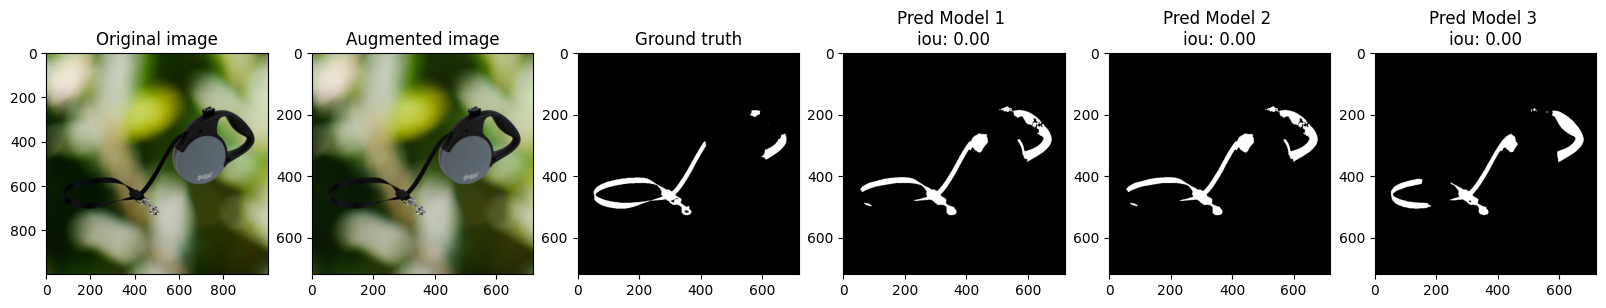

RuntimeError: The size of tensor a (900) must match the size of tensor b (720) at non-singleton dimension 2

In [69]:
plot_examples(ds_valid, model2, model2, model3, n=3)

## Model performance

In [14]:
model1_summary = get_inference_iou(model1, ds_valid)
model2_summary = get_inference_iou(model2, ds_valid)
model3_summary = get_inference_iou(model3, ds_valid)

In [20]:
model1_summary['prediction_iou'].astype(float).describe()

count    459.000000
mean       0.339881
std        0.220587
min        0.000000
25%        0.151193
50%        0.310348
75%        0.513360
max        0.890870
Name: prediction_iou, dtype: float64

In [15]:
fig = px.histogram(model1_summary,
                   x="prediction_iou",
                   title = 'Model 1 - IoU Distribution for Validation Set',
                   width=600, height=500, nbins = 30)
fig.show()

In [21]:
model2_summary['prediction_iou'].astype(float).describe()

count    459.000000
mean       0.420161
std        0.221673
min        0.000000
25%        0.249288
50%        0.400429
75%        0.591513
max        0.955610
Name: prediction_iou, dtype: float64

In [16]:
fig = px.histogram(model2_summary,
                   x="prediction_iou",
                   title = 'Model 2 - IoU Distribution for Validation Set',
                   width=600, height=500, nbins = 30)
fig.show()

In [22]:
model3_summary['prediction_iou'].astype(float).describe()

count    459.000000
mean       0.439019
std        0.226110
min        0.000000
25%        0.258827
50%        0.433005
75%        0.624073
max        0.945250
Name: prediction_iou, dtype: float64

In [17]:
fig = px.histogram(model3_summary,
                   x="prediction_iou",
                   title = 'Model 3 - IoU Distribution for Validation Set',
                   width=600, height=500, nbins = 30)
fig.show()

## Analyze model statistics

In [ ]:
# Check if output values are too large
model.eval()
model.to('cuda')
stats = []
with torch.no_grad():
    for idx, (x, y) in enumerate(ds_valid):
        if idx%10==0:
            print(idx)
        output = model(x[None].to('cuda'))[0].to('cpu')
        stats.append((idx, output.min(), output.max()))
stats

In [ ]:
# Check performance
model.eval()
model.to('cuda')
stats = []
with torch.no_grad():
    for idx, (x, y) in enumerate(ds_valid):
        output = model(x[None].to('cuda')).to('cpu')
        acc = torchtrainer.perf_funcs.segmentation_accuracy(output, y[None], ('iou', 'prec', 'rec'))
        stats.append((idx, *list(acc.items())))
stats

In [ ]:
# Check intermediate activations of the model
insp = torchtrainer.inspector.Inspector(model)
insp.start_tracking_activations()

model.eval()
model.to('cuda')
with torch.no_grad():
    output = model(ds_valid[0][0][None].to('cuda'))
acts = insp.get_activations()

stats = []
for k, v in acts.items():
    if v is not None:
        stats.append((k, v.min(), v.max()))
stats

In [ ]:
# Benchmark model

_model = torchtrainer.models.resunet.ResUNet((3,3,3), (16,32,64))
stats_train = torchtrainer.profiling.benchmark_model(_model, (8, 1, 256, 256), no_grad=False, call_backward=True, use_float16=True, return_model_info=False)
stats_val = torchtrainer.profiling.benchmark_model(_model, (8, 1, 1104, 1376), no_grad=True, call_backward=False, use_float16=True, return_model_info=False)
print(stats_train)
print(stats_val)

{'params': 0.0, 'activations': 0.0, 'flops': 0.0, 'memory': 0.4989638328552246, 'time_cpu': 0.01279592514038086, 'time_gpu': 0.032920574188232424, 'info': ['params: M', 'activations: G', 'flops: G', 'memory: GiB', 'time_cpu: s', 'time_gpu: s']}
{'params': 0.0, 'activations': 0.0, 'flops': 0.0, 'memory': 3.0343613624572754, 'time_cpu': 0.0055696964263916016, 'time_gpu': 0.18489549255371093, 'info': ['params: M', 'activations: G', 'flops: G', 'memory: GiB', 'time_cpu: s', 'time_gpu: s']}
